In [46]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [47]:
def projectile_motion_with_resistance(state, t, g, k, m):
    x, y, v_x, v_y = state
    n = 3
    dx_dt = v_x
    dy_dt = v_y
    dv_x_dt = -(k/m) * v_x**n 
    dv_y_dt = -g - (k/m) * v_y**n
    
    return [dx_dt, dy_dt, dv_x_dt, dv_y_dt]

# 定义参数
g = 9.8  # 重力加速度
k = 0.1  # 空气阻力系数
m = 1.0  # 物体质量

# 定义初始条件
x0 = 0.0  # 初始水平位置
y0 = 10  # 初始垂直位置
v_x0 = 2.0  # 初始水平速度
v_y0 = 0  # 初始垂直速度

# 定义时间点
ts = np.linspace(0, 2, 100)  # 从0到2秒，共取100个时间点

# 定义初始状态向量
initial_state = [x0, y0, v_x0, v_y0]

# 求解ODE方程组
solution_with_resistance = odeint(projectile_motion_with_resistance, initial_state, ts, args=(g, k, m))

# 提取位置和速度信息
x_with_resistance = solution_with_resistance[:, 0]
y_with_resistance = solution_with_resistance[:, 1]
v_x_with_resistance = solution_with_resistance[:, 2]
v_y_with_resistance = solution_with_resistance[:, 3]

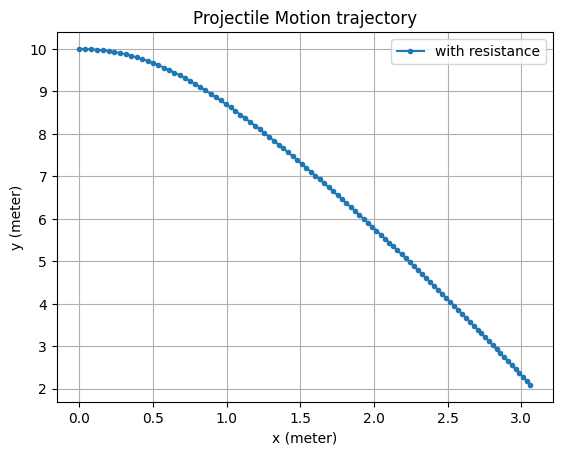

In [48]:
# 绘制轨迹
plt.plot(x_with_resistance, y_with_resistance, label = 'with resistance', marker='o', markersize = 3)
#plt.plot(state_list[:, 0], state_list[:, 1], label = 'Kalman Filter tracking', marker='o', markersize = 3)
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.title('Projectile Motion trajectory')
plt.grid(True)
plt.legend()
plt.show()

In [49]:
n_train = 20
t_train = ts[:n_train]
x_train = x_with_resistance[:n_train]
y_train = y_with_resistance[:n_train]
print(t_train)
print(x_train)
print(y_train)

[0.         0.02020202 0.04040404 0.06060606 0.08080808 0.1010101
 0.12121212 0.14141414 0.16161616 0.18181818 0.2020202  0.22222222
 0.24242424 0.26262626 0.28282828 0.3030303  0.32323232 0.34343434
 0.36363636 0.38383838]
[0.         0.04024211 0.08016544 0.11977747 0.15908536 0.19809601
 0.23681607 0.27525193 0.31340977 0.35129552 0.38891493 0.42627354
 0.4633767  0.50022957 0.53683716 0.5732043  0.60933566 0.64523577
 0.68090902 0.71635966]
[10.          9.99800022  9.99200133  9.98200569  9.96801947  9.95005448
  9.92812995  9.90227426  9.87252643  9.83893744  9.80157126  9.76050551
  9.71583177  9.66765544  9.61609516  9.56128195  9.50335766  9.44247341
  9.37878763  9.31246393]


In [50]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)
reg_in = reg_in[:,None]

reg_xlabel = torch.from_numpy(x_train).type(torch.float32)
reg_xlabel = reg_xlabel[:,None]

reg_ylabel = torch.from_numpy(y_train).type(torch.float32)
reg_ylabel = reg_ylabel[:,None]

print(reg_in.shape)
print(reg_xlabel.shape)
print(reg_ylabel.shape)

f_x = np.random.uniform(0, 5, n_f)
f_y = np.random.uniform(0, 5, n_f)
f_xt = np.random.uniform(0, 2, n_f)
f_yt = np.random.uniform(0, 2, n_f)
f_data_x = np.vstack([f_x, f_xt]).T
f_data_y = np.vstack([f_y, f_yt]).T

f_x = Variable(torch.from_numpy(f_data_x[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_xt = Variable(torch.from_numpy(f_data_x[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_y = Variable(torch.from_numpy(f_data_y[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_yt = Variable(torch.from_numpy(f_data_y[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_dataset_x = torch.utils.data.TensorDataset(f_x, f_xt)
f_dataset_y = torch.utils.data.TensorDataset(f_y, f_yt)
f_data_loader_x = torch.utils.data.DataLoader(f_dataset_x, batch_size = f_batch_size, shuffle=True)
f_data_loader_y = torch.utils.data.DataLoader(f_dataset_y, batch_size = f_batch_size, shuffle=True)

torch.Size([20, 1])
torch.Size([20, 1])
torch.Size([20, 1])


In [51]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 1):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model_x = MLP()
model_y = MLP()

def f_x(t, k, m, n):
    u = model_x(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    return u_tt + (k/m)*u_t**n

def f_y(t, k, m, n, g):
    u = model_y(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    return u_tt + (k/m)*u_t**n + g

optimizer_x = optim.Adam(model_x.parameters(), lr=1e-3)
optimizer_y = optim.Adam(model_y.parameters(), lr=1e-3)

In [52]:
# Training the PINN in x direction
n_epoch = 20
for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader_x):
        optimizer_x.zero_grad()
        pred = model_x(reg_in)
        reg_loss = torch.mean((reg_xlabel - pred) ** 2)
        f_loss = torch.mean(f_x(t, k, m, 3) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer_x.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

100%|██████████| 313/313 [00:01<00:00, 260.11it/s]


epoch = 0, loss = 0.00040556618478149176
epoch = 0, f_loss = 0.00012586971570271999
epoch = 0, reg_loss = 0.00027969645452685654


100%|██████████| 313/313 [00:01<00:00, 272.51it/s]


epoch = 1, loss = 0.0006902092136442661
epoch = 1, f_loss = 0.00010646916780387983
epoch = 1, reg_loss = 0.0005837400676682591


100%|██████████| 313/313 [00:01<00:00, 277.49it/s]


epoch = 2, loss = 5.572591908276081e-05
epoch = 2, f_loss = 5.262663762550801e-05
epoch = 2, reg_loss = 3.0992810025054496e-06


100%|██████████| 313/313 [00:01<00:00, 273.40it/s]


epoch = 3, loss = 0.00015162830823101103
epoch = 3, f_loss = 2.5300993002019823e-05
epoch = 3, reg_loss = 0.0001263273152289912


100%|██████████| 313/313 [00:01<00:00, 277.27it/s]


epoch = 4, loss = 0.00022616650676354766
epoch = 4, f_loss = 6.269299046834931e-05
epoch = 4, reg_loss = 0.00016347352357115597


100%|██████████| 313/313 [00:01<00:00, 251.63it/s]


epoch = 5, loss = 2.60829328908585e-05
epoch = 5, f_loss = 1.0677687896532007e-05
epoch = 5, reg_loss = 1.5405244994326495e-05


100%|██████████| 313/313 [00:01<00:00, 245.38it/s]


epoch = 6, loss = 0.00015279219951480627
epoch = 6, f_loss = 6.288890290306881e-05
epoch = 6, reg_loss = 8.990330388769507e-05


100%|██████████| 313/313 [00:01<00:00, 250.93it/s]


epoch = 7, loss = 0.00048478011740371585
epoch = 7, f_loss = 6.995578587520868e-05
epoch = 7, reg_loss = 0.0004148243460804224


100%|██████████| 313/313 [00:01<00:00, 272.37it/s]


epoch = 8, loss = 1.569424603076186e-05
epoch = 8, f_loss = 1.2351018085610121e-05
epoch = 8, reg_loss = 3.3432283998990897e-06


100%|██████████| 313/313 [00:01<00:00, 268.63it/s]


epoch = 9, loss = 0.0005927128368057311
epoch = 9, f_loss = 9.771612531039864e-05
epoch = 9, reg_loss = 0.0004949967260472476


100%|██████████| 313/313 [00:01<00:00, 264.58it/s]


epoch = 10, loss = 0.00027701357612386346
epoch = 10, f_loss = 9.968446829589084e-05
epoch = 10, reg_loss = 0.000177329100552015


100%|██████████| 313/313 [00:01<00:00, 283.87it/s]


epoch = 11, loss = 2.4965713237179443e-05
epoch = 11, f_loss = 1.7133561414084397e-05
epoch = 11, reg_loss = 7.832151823095046e-06


100%|██████████| 313/313 [00:01<00:00, 279.48it/s]


epoch = 12, loss = 0.0002610032679513097
epoch = 12, f_loss = 0.00022331583022605628
epoch = 12, reg_loss = 3.768744500121102e-05


100%|██████████| 313/313 [00:01<00:00, 270.74it/s]


epoch = 13, loss = 1.4535602531395853e-05
epoch = 13, f_loss = 8.445699677395169e-06
epoch = 13, reg_loss = 6.089902854000684e-06


100%|██████████| 313/313 [00:01<00:00, 266.57it/s]


epoch = 14, loss = 0.0007826237706467509
epoch = 14, f_loss = 0.0007224738947115839
epoch = 14, reg_loss = 6.0149875935167074e-05


100%|██████████| 313/313 [00:01<00:00, 275.74it/s]


epoch = 15, loss = 1.4252227629185654e-05
epoch = 15, f_loss = 6.919493444002001e-06
epoch = 15, reg_loss = 7.332734185183654e-06


100%|██████████| 313/313 [00:01<00:00, 284.30it/s]


epoch = 16, loss = 1.427430470357649e-05
epoch = 16, f_loss = 5.790269824501593e-06
epoch = 16, reg_loss = 8.484034879074898e-06


100%|██████████| 313/313 [00:01<00:00, 288.49it/s]


epoch = 17, loss = 5.20027333550388e-06
epoch = 17, f_loss = 4.319494109950028e-06
epoch = 17, reg_loss = 8.807793960841082e-07


100%|██████████| 313/313 [00:01<00:00, 286.23it/s]


epoch = 18, loss = 0.0005815154290758073
epoch = 18, f_loss = 0.00021035101963207126
epoch = 18, reg_loss = 0.0003711644094437361


100%|██████████| 313/313 [00:01<00:00, 282.27it/s]

epoch = 19, loss = 5.107122888148297e-06
epoch = 19, f_loss = 3.400099103600951e-06
epoch = 19, reg_loss = 1.7070238982341834e-06


In [53]:
# Train a pure MLP in x direction
model_mlp_x = MLP()
optimizer_mlp_x = optim.Adam(model_mlp_x.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp_x.zero_grad()
        pred = model_mlp_x(reg_in)
        mlp_loss = torch.mean((reg_xlabel - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp_x.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))

epoch = 0, loss = 0.24930903315544128
epoch = 1, loss = 0.059498630464076996
epoch = 2, loss = 0.07505638152360916
epoch = 3, loss = 0.11196613311767578
epoch = 4, loss = 0.08441199362277985
epoch = 5, loss = 0.04615100473165512
epoch = 6, loss = 0.033733099699020386
epoch = 7, loss = 0.045841388404369354
epoch = 8, loss = 0.05808594822883606
epoch = 9, loss = 0.054846424609422684
epoch = 10, loss = 0.040046822279691696
epoch = 11, loss = 0.025033006444573402
epoch = 12, loss = 0.018532520160079002
epoch = 13, loss = 0.021564770489931107
epoch = 14, loss = 0.02736467495560646
epoch = 15, loss = 0.02787894569337368
epoch = 16, loss = 0.02136157639324665
epoch = 17, loss = 0.012576577253639698
epoch = 18, loss = 0.007426687981933355
epoch = 19, loss = 0.00802508182823658
epoch = 20, loss = 0.011401427909731865
epoch = 21, loss = 0.012582460418343544
epoch = 22, loss = 0.009413661435246468
epoch = 23, loss = 0.004217821639031172
epoch = 24, loss = 0.0011606240877881646
epoch = 25, loss = 

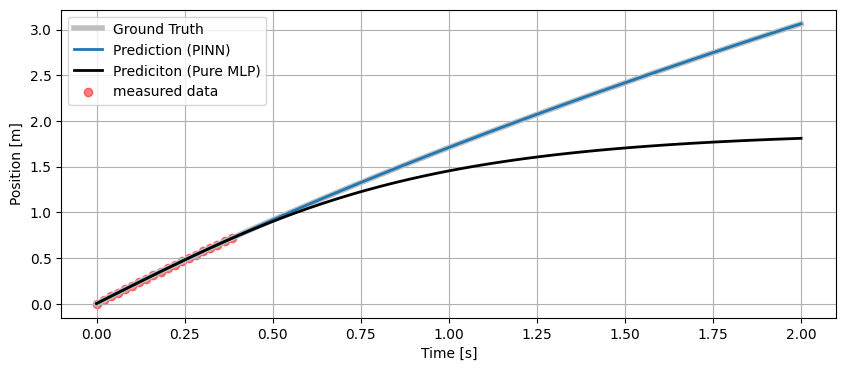

In [54]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, x_with_resistance,color = "silver", lw = 4)
plt.plot(ts, model_x( ts_torch ).detach().numpy(),lw = 2)
plt.plot(ts, model_mlp_x( ts_torch ).detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, x_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)

In [55]:
# Training the PINN in y direction
n_epoch = 20
for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader_y):

        optimizer_y.zero_grad()
        pred = model_y(reg_in)
        reg_loss = torch.mean((reg_ylabel - pred) ** 2)
        f_loss = torch.mean(f_y(t, k, m, 3, g) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer_y.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

100%|██████████| 313/313 [00:01<00:00, 250.79it/s]


epoch = 0, loss = 0.05407024547457695
epoch = 0, f_loss = 0.037748727947473526
epoch = 0, reg_loss = 0.016321517527103424


100%|██████████| 313/313 [00:01<00:00, 260.41it/s]


epoch = 1, loss = 0.004604893736541271
epoch = 1, f_loss = 0.004225035198032856
epoch = 1, reg_loss = 0.00037985859671607614


100%|██████████| 313/313 [00:01<00:00, 261.47it/s]


epoch = 2, loss = 0.001554627320729196
epoch = 2, f_loss = 0.0015211717691272497
epoch = 2, reg_loss = 3.3455500670243055e-05


100%|██████████| 313/313 [00:01<00:00, 280.01it/s]


epoch = 3, loss = 0.00035040819784626365
epoch = 3, f_loss = 0.00034104331280104816
epoch = 3, reg_loss = 9.364888683194295e-06


100%|██████████| 313/313 [00:01<00:00, 279.83it/s]


epoch = 4, loss = 0.0013819440500810742
epoch = 4, f_loss = 0.0012958950828760862
epoch = 4, reg_loss = 8.604898175690323e-05


100%|██████████| 313/313 [00:01<00:00, 275.50it/s]


epoch = 5, loss = 0.001216024742461741
epoch = 5, f_loss = 0.0012146861990913749
epoch = 5, reg_loss = 1.3385658803599654e-06


100%|██████████| 313/313 [00:01<00:00, 276.77it/s]


epoch = 6, loss = 0.00829884223639965
epoch = 6, f_loss = 0.008156140334904194
epoch = 6, reg_loss = 0.000142702367156744


100%|██████████| 313/313 [00:01<00:00, 256.59it/s]


epoch = 7, loss = 0.0037274574860930443
epoch = 7, f_loss = 0.0037233014591038227
epoch = 7, reg_loss = 4.1559765122656245e-06


100%|██████████| 313/313 [00:01<00:00, 277.83it/s]


epoch = 8, loss = 0.13714373111724854
epoch = 8, f_loss = 0.13332954049110413
epoch = 8, reg_loss = 0.003814196912571788


100%|██████████| 313/313 [00:01<00:00, 282.15it/s]


epoch = 9, loss = 0.001085836673155427
epoch = 9, f_loss = 0.0010805298807099462
epoch = 9, reg_loss = 5.306746970745735e-06


100%|██████████| 313/313 [00:01<00:00, 282.24it/s]


epoch = 10, loss = 0.0001662711292738095
epoch = 10, f_loss = 0.00016495252202730626
epoch = 10, reg_loss = 1.3186021305955364e-06


100%|██████████| 313/313 [00:01<00:00, 270.65it/s]


epoch = 11, loss = 0.0284787155687809
epoch = 11, f_loss = 0.027925856411457062
epoch = 11, reg_loss = 0.0005528593901544809


100%|██████████| 313/313 [00:01<00:00, 285.04it/s]


epoch = 12, loss = 0.00031073251739144325
epoch = 12, f_loss = 0.00031071307603269815
epoch = 12, reg_loss = 1.9439539755694568e-08


100%|██████████| 313/313 [00:01<00:00, 281.33it/s]


epoch = 13, loss = 0.006497855763882399
epoch = 13, f_loss = 0.0064954026602208614
epoch = 13, reg_loss = 2.452967009958229e-06


100%|██████████| 313/313 [00:01<00:00, 280.11it/s]


epoch = 14, loss = 0.13216398656368256
epoch = 14, f_loss = 0.12997092306613922
epoch = 14, reg_loss = 0.0021930686198174953


100%|██████████| 313/313 [00:01<00:00, 283.80it/s]


epoch = 15, loss = 8.316854655276984e-05
epoch = 15, f_loss = 8.161376172211021e-05
epoch = 15, reg_loss = 1.5547821021755226e-06


100%|██████████| 313/313 [00:01<00:00, 275.07it/s]


epoch = 16, loss = 0.1589379608631134
epoch = 16, f_loss = 0.15854746103286743
epoch = 16, reg_loss = 0.0003905048070009798


100%|██████████| 313/313 [00:01<00:00, 268.02it/s]


epoch = 17, loss = 0.00017329490219708532
epoch = 17, f_loss = 0.00016624567797407508
epoch = 17, reg_loss = 7.049226951494347e-06


100%|██████████| 313/313 [00:01<00:00, 276.54it/s]


epoch = 18, loss = 9.905298793455586e-05
epoch = 18, f_loss = 9.872524969978258e-05
epoch = 18, reg_loss = 3.277392295331083e-07


100%|██████████| 313/313 [00:01<00:00, 282.27it/s]

epoch = 19, loss = 6.33356612524949e-05
epoch = 19, f_loss = 6.19491474935785e-05
epoch = 19, reg_loss = 1.3865170558347018e-06


In [56]:
# Train a pure MLP in y direction
model_mlp_y = MLP()
optimizer_mlp_y = optim.Adam(model_mlp_y.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp_y.zero_grad()
        pred = model_mlp_y(reg_in)
        mlp_loss_y = torch.mean((reg_ylabel - pred) ** 2)
        mlp_loss_y.backward()
        optimizer_mlp_y.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss_y))



epoch = 0, loss = 92.93035888671875
epoch = 1, loss = 86.55521392822266
epoch = 2, loss = 80.2515640258789
epoch = 3, loss = 73.95738220214844
epoch = 4, loss = 67.61872863769531
epoch = 5, loss = 61.227027893066406
epoch = 6, loss = 54.83562088012695
epoch = 7, loss = 48.54901885986328
epoch = 8, loss = 42.49960708618164
epoch = 9, loss = 36.820255279541016
epoch = 10, loss = 31.620357513427734
epoch = 11, loss = 26.970687866210938
epoch = 12, loss = 22.898563385009766
epoch = 13, loss = 19.392147064208984
epoch = 14, loss = 16.410419464111328
epoch = 15, loss = 13.895062446594238
epoch = 16, loss = 11.781150817871094
epoch = 17, loss = 10.005030632019043
epoch = 18, loss = 8.509020805358887
epoch = 19, loss = 7.243586540222168
epoch = 20, loss = 6.167688846588135
epoch = 21, loss = 5.248143196105957
epoch = 22, loss = 4.458496570587158
epoch = 23, loss = 3.777801990509033
epoch = 24, loss = 3.189483165740967
epoch = 25, loss = 2.6803414821624756
epoch = 26, loss = 2.2397665977478027


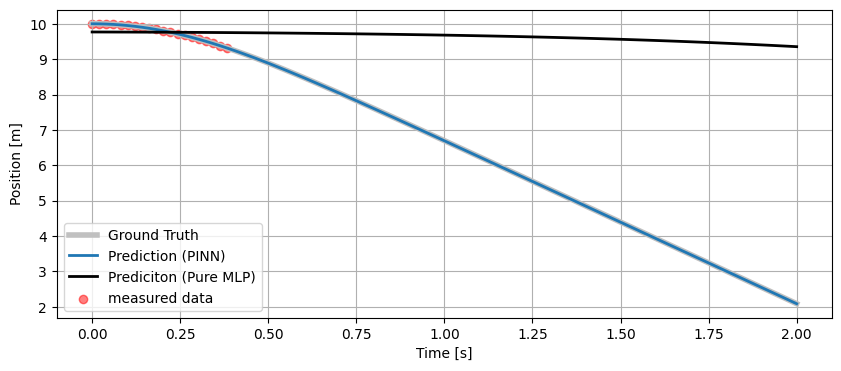

In [57]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, y_with_resistance,color = "silver", lw = 4)
plt.plot(ts, model_y( ts_torch ).detach().numpy(),lw = 2)
plt.plot(ts, model_mlp_y( ts_torch ).detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, y_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)

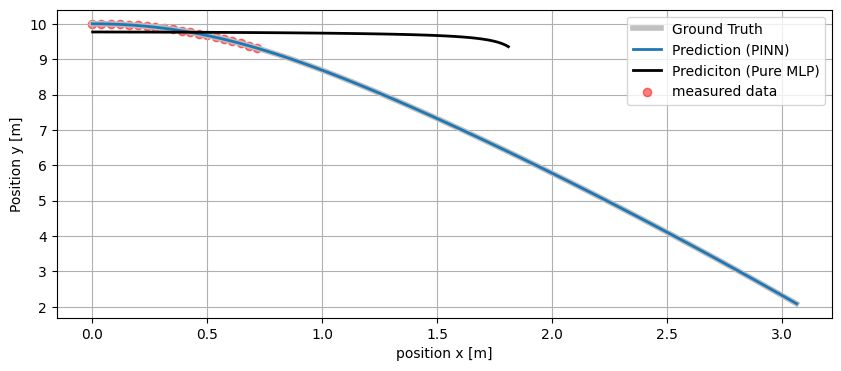

In [58]:
plt.figure(figsize=(10, 4))
plt.plot(x_with_resistance, y_with_resistance,color = "silver", lw = 4)
plt.plot(model_x( ts_torch ).detach().numpy(), model_y( ts_torch ).detach().numpy(),lw = 2)
plt.plot(model_mlp_x( ts_torch ).detach().numpy(), model_mlp_y( ts_torch ).detach().numpy(), color = "black", lw = 2)
plt.scatter(x_train, y_train,alpha=0.5, c = "red")
plt.xlabel('position x [m]')
plt.ylabel('Position y [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)